<a href="https://colab.research.google.com/github/gizelleguerra/img_processing_practice/blob/main/super_gradients_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install super_gradients
!pip install dagshub mlflow --quiet
!pip install matplotlib==3.1.3 --quiet
!python -m pip install --upgrade pillow==9.2.0 --quiet
!pip install --upgrade Pillow --quiet

  Using cached matplotlib-3.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached treelib-1.6.1-py3-none-any.whl
  Attempting uninstall: treelib
    Found existing installation: treelib 1.6.4
    Uninstalling treelib-1.6.4:
      Successfully uninstalled treelib-1.6.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dagshub 0.3.27 requires treelib~=1.6.4, but you have treelib 1.6.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
super-gradients 3.7.1 requires treelib==1.6.1, but you have treelib 1.6.4 which is incompa

In [ ]:
import os

import requests
import torch
from PIL import Image

from dagshub.streaming import install_hooks

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)

The console stream is logged into /root/sg_logs/console.log


[2024-06-10 17:33:53] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-06-10 17:34:05] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-06-10 17:34:09] WARNING - env_sanity_check.py - Failed to verify installed packages: matplotlib==3.1.3 does not satisfy requirement matplotlib>=3.3.4


In [ ]:
trainer = Trainer(experiment_name="pascal_voc_detection", ckpt_root_dir="./train_models")

In [ ]:
from super_gradients.training import dataloaders


class_inclusion_list = ["car", "person"]
num_classes = len(class_inclusion_list)
train_dataloader = dataloaders.get(name='pascal_voc_detection_train',
                                   dataset_params={"class_inclusion_list": class_inclusion_list},
                                   dataloader_params={'num_workers': 2}
                                   )

val_dataloader = dataloaders.get(name='pascal_voc_detection_val',
                                 dataset_params={"class_inclusion_list": class_inclusion_list},
                                 dataloader_params={'num_workers': 2}
                                 )

[2024-06-10 17:34:10] INFO - utils.py - Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar to data/pascal_voc/images/VOCtrainval_06-Nov-2007.tar...
100%|██████████| 439M/439M [00:18<00:00, 24.8MB/s]
[2024-06-10 17:34:29] INFO - utils.py - Extracting to data/pascal_voc/images...
[2024-06-10 17:34:33] INFO - utils.py - Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar to data/pascal_voc/images/VOCtest_06-Nov-2007.tar...
100%|██████████| 430M/430M [00:17<00:00, 25.6MB/s]
[2024-06-10 17:34:50] INFO - utils.py - Extracting to data/pascal_voc/images...
[2024-06-10 17:34:54] INFO - utils.py - Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar to data/pascal_voc/images/VOCtrainval_11-May-2012.tar...
100%|██████████| 1.86G/1.86G [01:14<00:00, 26.8MB/s]
[2024-06-10 17:36:09] INFO - utils.py - Extracting to data/pascal_voc/images...
test2007: 100%|██████████| 4952/4952 [00:02<00:00, 2365.93it/

Indexing dataset annotations: 100%|██████████| 4952/4952 [00:01<00:00, 2568.23it/s]


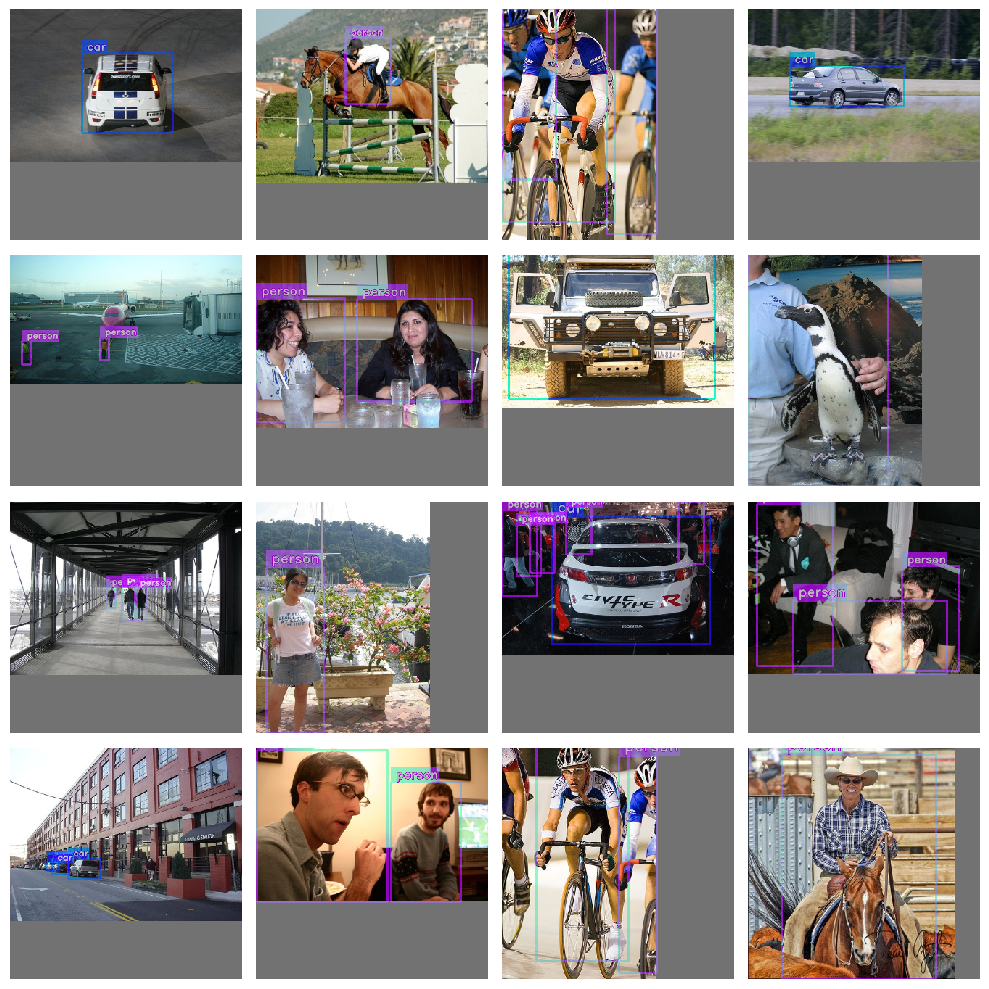

In [ ]:
train_dataloader.dataset.datasets[0].plot()

In [ ]:
train_dataloader.dataloader_params

{'num_workers': 2,
 'shuffle': True,
 'batch_size': 16,
 'drop_last': True,
 'pin_memory': True,
 'worker_init_fn': <function super_gradients.training.datasets.datasets_utils.worker_init_reset_seed(worker_id)>,
 'collate_fn': <super_gradients.training.utils.collate_fn.detection_collate_fn.DetectionCollateFN at 0x7a55676bb9a0>}

In [ ]:
train_dataloader.dataset.dataset_params

{'data_dir': './data/pascal_voc/', 'input_dim': [320, 320], 'transforms': [{'DetectionPaddedRescale': {'input_dim': [320, 320]}}, {'DetectionTargetsFormatTransform': {'input_dim': [320, 320], 'output_format': 'LABEL_CXCYWH'}}], 'images_dir': 'images', 'labels_dir': 'labels', 'class_inclusion_list': ['car', 'person'], 'max_num_samples': None, 'download': True}

In [ ]:
from super_gradients.training import Trainer, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)


In [ ]:
model = models.get("yolo_nas_m",
                   num_classes=len(train_dataloader.dataset.dataset_params["class_inclusion_list"]),
                   pretrained_weights="coco"
                   )

[2024-06-10 17:39:18] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-06-10 17:39:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:06<00:00, 30.6MB/s]
[2024-06-10 17:39:25] INFO - checkpoin

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    # "warmup_initial_lr": 1e-2,#1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 1e-2,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "SGD",
    # "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 3,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(train_dataloader.dataset.dataset_params["class_inclusion_list"]),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(train_dataloader.dataset.dataset_params["class_inclusion_list"]),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_dataloader,
              valid_loader=val_dataloader)

[2024-06-10 17:52:49] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240610_175249_667363`
[2024-06-10 17:52:49] INFO - sg_trainer.py - Checkpoints directory: ./train_models/pascal_voc_detection/RUN_20240610_175249_667363
[2024-06-10 17:52:49] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to ./train_models/pascal_voc_detection/RUN_20240610_175249_667363/console_Jun10_17_52_49.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0745
│   ├── Ppyoloeloss/loss_iou = 0.534
│   ├── Ppyoloeloss/loss_dfl = 0.5544
│   └── Ppyoloeloss/loss = 2.1629
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0191
    ├── Ppyoloeloss/loss_iou = 0.5247
    ├── Ppyoloeloss/loss_dfl = 0.542
    ├── Ppyoloeloss/loss = 2.0859
    ├── Precision@0.50 = 0.049
    ├── Recall@0.50 = 0.8102
    ├── Map@0.50 = 0.4857
    ├── F1@0.50 = 0.092
    └── Best_score_threshold = 0.35



Validating epoch 1: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
[2024-06-10 17:59:34] INFO - base_sg_logger.py - Checkpoint saved in ./train_models/pascal_voc_detection/RUN_20240610_175249_667363/ckpt_best.pth
[2024-06-10 17:59:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5049230456352234


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0421
│   │   ├── Epoch N-1      = 1.0745 (↘ -0.0324)
│   │   └── Best until now = 1.0745 (↘ -0.0324)
│   ├── Ppyoloeloss/loss_iou = 0.5165
│   │   ├── Epoch N-1      = 0.534  (↘ -0.0175)
│   │   └── Best until now = 0.534  (↘ -0.0175)
│   ├── Ppyoloeloss/loss_dfl = 0.5365
│   │   ├── Epoch N-1      = 0.5544 (↘ -0.0178)
│   │   └── Best until now = 0.5544 (↘ -0.0178)
│   └── Ppyoloeloss/loss = 2.0951
│       ├── Epoch N-1      = 2.1629 (↘ -0.0677)
│       └── Best until now = 2.1629 (↘ -0.0677)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9936
    │   ├── Epoch N-1      = 1.0191 (↘ -0.0255)
    │   └── Best until now = 1.0191 (↘ -0.0255)
    ├── Ppyoloeloss/loss_iou = 0.5018
    │   ├── Epoch N-1      = 0.5247 (↘ -0.0229)
    │   └── Best until now = 0.5247 (↘ -0.0229)
    ├── Ppyoloeloss/loss_dfl = 0.5265
    │   ├── Epoch N-1      = 0.542  (↘ -0.0156)
    │   └── Best until now = 0.542  (↘ -0.0156)
    ├── Ppyoloeloss/lo

Validating epoch 2: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
[2024-06-10 18:02:54] INFO - base_sg_logger.py - Checkpoint saved in ./train_models/pascal_voc_detection/RUN_20240610_175249_667363/ckpt_best.pth
[2024-06-10 18:02:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5918793082237244


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9993
│   │   ├── Epoch N-1      = 1.0421 (↘ -0.0428)
│   │   └── Best until now = 1.0421 (↘ -0.0428)
│   ├── Ppyoloeloss/loss_iou = 0.4982
│   │   ├── Epoch N-1      = 0.5165 (↘ -0.0183)
│   │   └── Best until now = 0.5165 (↘ -0.0183)
│   ├── Ppyoloeloss/loss_dfl = 0.5217
│   │   ├── Epoch N-1      = 0.5365 (↘ -0.0148)
│   │   └── Best until now = 0.5365 (↘ -0.0148)
│   └── Ppyoloeloss/loss = 2.0192
│       ├── Epoch N-1      = 2.0951 (↘ -0.076)
│       └── Best until now = 2.0951 (↘ -0.076)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9619
    │   ├── Epoch N-1      = 0.9936 (↘ -0.0317)
    │   └── Best until now = 0.9936 (↘ -0.0317)
    ├── Ppyoloeloss/loss_iou = 0.4809
    │   ├── Epoch N-1      = 0.5018 (↘ -0.0209)
    │   └── Best until now = 0.5018 (↘ -0.0209)
    ├── Ppyoloeloss/loss_dfl = 0.5108
    │   ├── Epoch N-1      = 0.5265 (↘ -0.0157)
    │   └── Best until now = 0.5265 (↘ -0.0157)
    ├── Ppyoloeloss/loss

[2024-06-10 18:03:01] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 3: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


In [ ]:
import requests

forklift_url = "https://universe.roboflow.com/ds/BU1cgUCFTL?key=h6z4KgGkrE"

response = requests.get(forklift_url)
print(response.status_code)
# DONT WRITE TO ZIP FILE - ZIPFILE LIBRARY WONT DOWNLOAD
with open("forklift_data.zip", mode="wb") as file:
  file.write(response.content)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


200
